## 泰坦尼克号幸存分析 - Titanic Survival Analysis

### 简介 - Introduction

这个笔记本用于分析泰坦尼克号乘客的生存机会，依据是他们的**社会经济地位**（以船舱等级为代表）、**性别**、**年龄**和**登船港口**。

我们使用的数据集已命名titanic_data.csv，可在[此处](http://bit.ly/kaggletrain)获得。

我们的基础数据集将包含以下关键数据列：

- Pclass - (船舱等级)
- Sex -(性别)
- Age -(年龄)
- Embarked - (登船港口)

关于舱位数据源为1、2、3，为方便描述，我做了如下对应：

- 1 - 头等舱
- 2 - 商务舱
- 3 - 杰克舱

确切地说，我们将从以下几个方面进行分析：

- 船舱等级对生存机会的影响？
- 性别对生存机会的影响？
- 年龄对生存机会的影响？
- 在哪儿登船对生存机会的影响？

我们将首先要建立DataFrame并对数据做必要的处理，如有必要，我们还将在分析期间删除异常值。

我们还将定义两个函数get_count()和gen_plot()，这将在分析过程中节省时间。

### 准备数据集 - Preparing the dataset for analysis

In [5]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv('http://bit.ly/kaggletrain')
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


重置索引以方便后面使用

In [7]:
df = df.set_index(['PassengerId'])
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
def get_nan_count(column):
    '''
    column - 我们希望获得NaN值数量所在的列
    该函数返回特定列中NaN值的数量
    '''
    nan_count = column.isnull().sum()
    return nan_count

In [9]:
get_nan_count(df['Age']) # 说明原始数据中用177人的年龄数据没有登记，这也无法保证后续数据分析的准确性，这是没办法的事儿

177

In [10]:
get_nan_count(df['Embarked']) # 登船港口有2人的数据缺失

2

值得庆幸的是，由于**船舱等级**和**性别**数据的完整性，可以提供我们较为真实客观的分析结果，同时我们也将忽略**年龄**和**登船**栏的缺失值。

由于**年龄**一栏在891名乘客中有177个空值，分析结果将不太可靠，仅做参考。

### 探索和分析数据 - Exploring and analyzing the data

因为我们要从4个不同的维度来分析船上的存活率，所以我们定义了一个比率计算函数。

In [11]:
survivor_count = df['Survived'].sum()

def get_survival_rate(dataframe, factor):
    '''
    df - 适用于分析的数据框架
    factor - 我们希望得到生存率的因素(列)。
    函数接收一个列，并根据这个列返回泰坦尼克号乘客的存活率。
    '''
    by_factor = dataframe.groupby(factor)
    count_by_factor = by_factor['Survived'].sum()
    survival_rate = count_by_factor / survivor_count * 100
    print('Survival rates:', survival_rate, '\n \n', 'Counts: ', count_by_factor)
    return survival_rate, count_by_factor

### 存活率和票价等级的相关性 - Correlation between survival and ticket class

让我们看看社会经济地位是如何影响生存的。

首先，我们应该对舱位等级对应的乘客总数有个粗略的了解。

In [12]:
total_passenger_count = len(df['Pclass'])
first_class_count = (df['Pclass'] == 1).sum()
second_class_count = (df['Pclass'] == 2).sum()
third_class_count = (df['Pclass'] == 3).sum()

per_first_class =  first_class_count / total_passenger_count * 100
per_second_class = second_class_count / total_passenger_count * 100
per_third_class = third_class_count / total_passenger_count * 100

In [13]:
print('头等舱比例 = %.2f%%'% per_first_class, ' | 舱位人数: ', first_class_count)
print('公务舱比例 = %.2f%%'% per_second_class, ' | 舱位人数: ', second_class_count)
print('杰克舱比例 = %.2f%%'% per_third_class, ' | 舱位人数: ', third_class_count)

头等舱比例 = 24.24%  | 舱位人数:  216
公务舱比例 = 20.65%  | 舱位人数:  184
杰克舱比例 = 55.11%  | 舱位人数:  491


通过上面数据我们可以看出：

- 头等舱约占船上乘客总数的四分之一（约24%）。
- 公务舱只占船上乘客的四分之一不到（约21%）。
- 杰克舱占船上乘客的一半以上（约55%）。

接下来让我们把这些数据与生存百分比进行比较。

In [14]:
get_survival_rate(df, 'Pclass')

Survival rates: Pclass
1    39.766082
2    25.438596
3    34.795322
Name: Survived, dtype: float64 
 
 Counts:  Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64


(Pclass
 1    39.766082
 2    25.438596
 3    34.795322
 Name: Survived, dtype: float64, Pclass
 1    136
 2     87
 3    119
 Name: Survived, dtype: int64)

通过上面所得生存率，我们可以看到：

- **头等舱**乘客占船上总人数的24%，其中40%的人员幸存
- **公务舱**乘客占船上总人数的21%，其中25%的人员幸存
- **杰克舱**乘客占船上总人数的55%，其中34%的人员幸存

下面我们会把这些结果可视化，这样会更为直观地理解这些数据。

准确地说，让我们看看存活率和死亡率是如何根据船舱等级，以绝对数量和百分比的方式进行展现的。

我们首先要定义一个函数get_counts()，它允许我们根据特定的质量来获得死亡和生存的精确计数。

我们将在整个分析过程中重复使用这个函数（除了我们的年龄分析）。

In [15]:
def get_counts(dataframe, factor, quality, status):
    '''
    dataframe - 应用该函数的数据框架
    factor - 执行分析的列
    quality - 执行分析的质量
    status - 你想计算的状态：生存或死亡。应该是一个布尔值（1代表生存，0代表死亡）。
    '''
    target = dataframe[factor].where(dataframe[factor] == quality)
    class_count = target.where(dataframe['Survived'] == status).count()
    return class_count

In [16]:
class1_survival_count = get_counts(df, 'Pclass', 1, 1)
class2_survival_count = get_counts(df, 'Pclass', 2, 1)
class3_survival_count = get_counts(df, 'Pclass', 3, 1)
class1_death_count = get_counts(df, 'Pclass', 1, 0)
class2_death_count = get_counts(df, 'Pclass', 2, 0)
class3_death_count = get_counts(df, 'Pclass', 3, 0)

In [17]:
print('按舱位统计生存人数')
print('头等舱:', class1_survival_count)
print('公务舱:', class2_survival_count)
print('杰克舱:', class3_survival_count)
print('\n按舱位统计死亡人数')
print('头等舱:', class1_death_count)
print('公务舱:', class2_death_count)
print('杰克舱:', class3_death_count)

按舱位统计生存人数
头等舱: 136
公务舱: 87
杰克舱: 119

按舱位统计死亡人数
头等舱: 80
公务舱: 97
杰克舱: 372


In [18]:
现在我们有了数据，可以将结果可视化了。

我们将定义第二个辅助函数gen_plot()，它将生成两个柱状图：一个绘制绝对值，另一个绘制百分比。

SyntaxError: invalid character in identifier (<ipython-input-18-d6d7d0faa82d>, line 1)

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# 中文处理
import matplotlib

# 使用中文字体
matplotlib.rcParams['font.family'] = ['Heiti TC']

def gen_plot(survival_array, death_array, by_factor, x_ticks):
    """
    survival_array：一个提供被分析的生存数据的列表
    death_array：提供被分析的死亡数据的列表
    by_title：分析的重点因素
    x_ticks：例如: ['头等舱', '二等舱', '三等舱']
    """
    
    abs_survival_list = np.array(survival_array)
    abs_death_list = np.array(death_array)
    N = len(abs_survival_list)
    ind = np.arange(N)
    width = 1 / N

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))


    # 按数量统计
    
    ax1.bar(ind, abs_survival_list, width, label='生存', alpha=0.8) # Survival
    ax1.bar(ind, abs_death_list, width, color='#d62728', label='死亡', alpha=0.8, bottom=abs_survival_list) # Death

    plt.sca(ax1)
    plt.xticks(ind, x_ticks)

    ax1.set_title(by_factor+'（按数量统计）',fontproperties=prop) # Absolute count
    ax1.set_ylabel('人数', fontproperties=prop) # Count
    ax1.legend(loc='upper left')

    plt.setp(plt.gca().get_xticklabels(), rotation=0) # rotation=45

    # 按比例统计
    per_survival_list = (abs_survival_list / (abs_survival_list + abs_death_list)) * 100
    per_death_list = (abs_death_list / (abs_survival_list + abs_death_list)) * 100

    ax2.bar(ind, per_survival_list, width, label='幸存比例', alpha=0.8)
    ax2.bar(ind, per_death_list, width, color='#d62728', label='死亡比例', alpha=0.8, bottom=per_survival_list)

    plt.sca(ax2)
    plt.xticks(ind, x_ticks)

    ax2.set_title(by_factor+'（按比例统计）')
    ax2.set_ylabel('比例')

    plt.setp(plt.gca().get_xticklabels(), rotation=0) # rotation=45
    ax2.figure.savefig('desktop/按比例统计%s.png' % by_factor, dpi=300)
    

    return plt.show()

In [62]:
# 在线模式展示图表
%matplotlib inline

我们现在可以绘制柱状图以进行**舱位**分析。

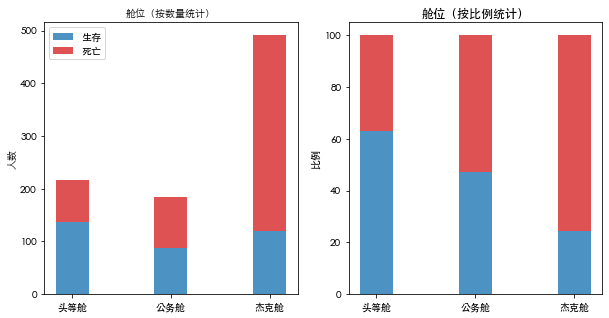

In [63]:
gen_plot([class1_survival_count, class2_survival_count, class3_survival_count],
         [class1_death_count, class2_death_count, class3_death_count],
         '舱位',
         ['头等舱', '公务舱', '杰克舱'])

我们可以看到，死亡几率和舱位等级之间有明显的关联：你的舱位等级越高，你的生存机会也就越高。

In [64]:
stats.chisquare(df['Survived'], df['Pclass'])

Power_divergenceResult(statistic=1592.1666666666665, pvalue=2.0399395484622444e-42)

### 生成几率和性别之间的关联

现在让我们分析一下性别对生存机会的影响。

首先，我们将定义一个类似于票务类的函数，以获得按性别分列的生存者和死亡人数。

In [65]:
female_survival_count = get_counts(df, 'Sex', 'female', 1)
male_survival_count = get_counts(df, 'Sex', 'male', 1)
female_death_count = get_counts(df, 'Sex', 'female', 0)
male_death_count = get_counts(df, 'Sex', 'male', 0)

In [66]:
print('按性别区分的幸存人数')
print('女性幸存者: ', female_survival_count)
print('男性幸存者: ', male_survival_count)
print('\n按性别区分的死亡人数')
print('女性死亡人数: ', female_death_count)
print('男性死亡人数: ', male_death_count)

按性别区分的幸存人数
女性幸存者:  233
男性幸存者:  109

按性别区分的死亡人数
女性死亡人数:  81
男性死亡人数:  468


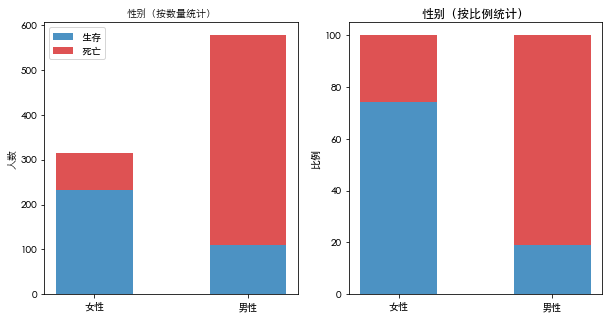

In [67]:
gen_plot([female_survival_count, male_survival_count],
         [female_death_count, male_death_count],
         '性别',
         ['女性', '男性'])

让我们给它加上一个数字。

首先，我们需要创建一个新的DataFrame，在这里我们将替换非int值：女性将是1，男性将是0。

In [68]:
gender_df = df[['Sex', 'Survived']]
gender_df.replace(['male', 'female'], [0, 1], inplace=True)

gender_df[['Sex', 'Survived']].corr(method='pearson')

,Sex,Survived
Sex,1.000000,0.543351
Survived,0.543351,1.000000


根据以上的分析，我们得出生存和性别之间有适度的相关性的结论。

女性比男性有更高的生存机会

头等舱的乘客比杰克舱的乘客有更高的生存机会

那么头等舱女性的生存机会与三等舱男性的生存机会相比如何？

In [69]:
df.groupby(['Sex', 'Pclass'])['Survived'].mean() * 100

Sex     Pclass
female  1         96.808511
        2         92.105263
        3         50.000000
male    1         36.885246
        2         15.740741
        3         13.544669
Name: Survived, dtype: float64

- 头等舱女性的生存机会：≈96.80%
- 杰克舱男人的生存机会：≈13.54%

这无疑解释了只要学好Pandas之后的杰克，应该早就预测到了电影的结局...

### 生存几率与年龄之间地关联关系

**线性回归分析**

现在我们要研究的是年龄对生存机会的影响。

我们要看一下与老年人相比儿童的存活率会怎么样。

记住，我们这里有177个NaN（非数字）值。我们将不得不把我们的数据削减20%。
这并不理想，你应该总是试图找到一个解决方案，以保存尽可能多的数据，但在像这样的情况下，我们真的没有选择。

首先，让我们摆脱 NaN 值

In [70]:
df_age = df[['Age' , 'Survived']].dropna(how='any')
df_age['Age'] = (np.floor(df_age['Age'])).astype(int)
df_age.shape

(714, 2)

In [71]:
df_age.head()

,Age,Survived
PassengerId,,
1,22,0
2,38,1
3,26,1
4,35,1
5,35,0


我们统计了177个缺失值。

在删除它们之后，我们得到一个有714行的新数据框架df_age。

In [73]:
print('最年轻的: ' + str(df_age['Age'].min() * 12) + '月')
print('\n最年长的: ' + str(df_age['Age'].max()) + '岁')

最年轻的: 0月

最年长的: 80岁


为了这次分析，我们把年龄四舍五入，所以船上最年轻的乘客只有几个月大，而最年长的是80岁。

现在让我们对数据进行排序，并创建一个新的DataFrame df_ages_survival。它将以年龄为索引。每个年龄段有4列，将给我们提供以下信息。

- 指数年龄的乘客存活的人数

- 死亡的指数年龄的乘客人数

- 指数年龄的乘客总数

- 该指数年龄的幸存者的百分比

In [74]:
ages_list = df_age['Age'].unique()
ages_list.sort()
ages_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 70,
       71, 74, 80])

In [80]:
df_ages_survival = pd.DataFrame(index=ages_list, columns=['幸存', '死亡', '合计', '比例'])

df_ages_survival['幸存'] = df_age.groupby('Age')['Survived'].sum()
df_ages_survival['合计'] = df_age.groupby('Age').count()
df_ages_survival['死亡'] = df_ages_survival['合计'] - df_ages_survival['幸存']
df_ages_survival['比例'] = round(df_age.groupby('Age')['Survived'].mean() * 100, 2)

# for age in ages_list:
#     df_ages_survival.loc[age]['Survived'] = (df_age['Age'] == age).where(df_age['Survived'] == 1).sum()
#     df_ages_survival.loc[age]['Total'] = (df_age['Age'] == age).sum()
#     df_ages_survival.loc[age]['Deaths'] = df_ages_survival.loc[age]['Total'] - df_ages_survival.loc[age]['Survived']
#     df_ages_survival.loc[age]['Percentage'] = (df_ages_survival.loc[age]['Survived'] / df_ages_survival.loc[age]['Total']) * 100
#     
# df_ages_survival.head()

df_ages_survival.head()

,幸存,死亡,合计,比例
0,7,0,7,100.00
1,5,2,7,71.43
2,3,7,10,30.00
3,5,1,6,83.33
4,7,3,10,70.00


让我们看看我们的数据的散点图，看看我们是否能识别任何异常值。

In [92]:
# 使用本地已有字体文件
import matplotlib.font_manager

font_zh=matplotlib.font_manager.FontProperties(fname='/users/liqiang/Downloads/超清区常用字幕字体/造字工房坚黑常规体.ttf')

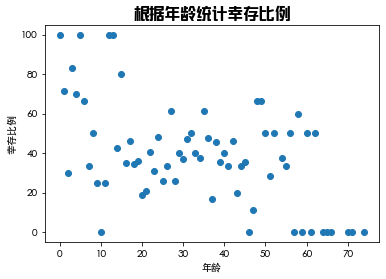

In [93]:
x = df_ages_survival['比例'].index
y = df_ages_survival['比例']
plt.scatter(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.title('根据年龄统计幸存比例',fontproperties=font_zh, fontsize=15)
plt.xlabel('年龄')
plt.ylabel('幸存比例')
plt.show()

我们可以确定一种趋势，其中较低的 y 值代表较高的 x 坐标，而较高的 y 值代表较低的 x 坐标。

这意味着，很明显，你越年轻，你生存的机会就越大。

然而，在图表的右上角有三个点似乎是异常值。

它们不能代表一般的趋势: 让我们识别它们，将它们从 DataFrame 中删除，重新绘制它并适合一条回归线。

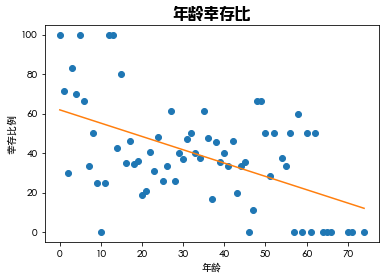

In [94]:
df_ages_survival = df_ages_survival.drop(df_ages_survival[(df_ages_survival['比例'] == 100) & (df_ages_survival.index > 50)].index)
x = df_ages_survival['比例'].index
y = df_ages_survival['比例']
plt.scatter(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, m*x + b, '-')
plt.title('年龄幸存比',fontproperties=font_zh, fontsize=15)
plt.xlabel('年龄')
plt.ylabel('幸存比例')
plt.show()

回归线清楚地表明，你越**年轻**，你的生存机会就越高。让我们来了解一下回归线的信息（尤其是斜率）。

In [95]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print('Slope: ', slope)
print('Intercept: ', intercept)
print('r_value: ', r_value)
print('r_squared: ', r_value ** 2)
print('p_value: ', p_value)
print('std_error: ', std_err)

Slope:  -0.6731448575214685
Intercept:  61.93830324815576
r_value:  -0.5279643944469163
r_squared:  0.2787464018036991
p_value:  3.7119198819981097e-06
std_error:  0.13328335798924698


现在这已经足够获得一些深入的了解，但是也许还有一个更好的方法来可视化这些数据。

让我们根据生存状态绘制一个年龄的核密度估计:

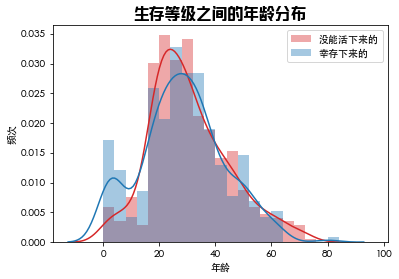

In [100]:
age_bins = np.arange(0, 100, 4)
sns.distplot(df.loc[(df['Survived']==0) & (~df['Age'].isnull()),'Age'], bins=age_bins, color='#d62728')
sns.distplot(df.loc[(df['Survived']==1) & (~df['Age'].isnull()),'Age'], bins=age_bins)
plt.title('生存等级之间的年龄分布',fontproperties=font_zh, fontsize=15)
plt.ylabel('频次')
plt.xlabel('年龄')
plt.legend(['没能活下来的', '幸存下来的'])
plt.show()

我们可以肯定地看到，当年龄较小时，存活乘客的分布会出现尖峰，这表明儿童的存活率较高。

### 特定年龄分析

我们将继续并加强我们的分析，对两个具体的年龄段进行更多的说明，这样我们也有一个基准。我们将使用一个条形图。

我们将分析6岁和12岁，但你可以用你选择的年龄来改变我们要定义的函数中的年龄参数。

下面是一个类似于get_counts的新函数。它将适合我们分析的劣等条件，并返回两种配置的生存和死亡计数，以用户定义的年龄作为参数。

In [101]:
def get_age_counts(age):
    '''
    age - 适用于分析的年龄限制
    该函数依次返回小于或等于指定年龄的人和大于指定年龄的人的生存数。
    以及小于或等于指定年龄的人和大于指定年龄的人的死亡数。
    '''
    younger_target = df['Age'].where(df['Age'] <= age)
    older_target = df['Age'].where(df['Age'] > age)
    younger_survival_count = younger_target.where(df['Survived'] == 1).count()
    older_survival_count = older_target.where(df['Survived'] == 1).count()
    younger_death_count = younger_target.where(df['Survived'] == 0).count()
    older_death_count = older_target.where(df['Survived'] == 0).count()
    return younger_survival_count, older_survival_count, younger_death_count, older_death_count

In [103]:
up_to_6_survival_count, over_6_survival_count, up_to_6_death_count, over_6_death_count = get_age_counts(6)
up_to_12_survival_count, over_12_survival_count, up_to_12_death_count, over_12_death_count = get_age_counts(12)

print('年龄限定=6')
print('6岁以下儿童的存活人数: ', up_to_6_survival_count)
print('6岁以上人群的生存人数: ', over_6_survival_count)
print('6岁以下儿童的死亡人数: ', up_to_6_death_count)
print('6岁以上人群的死亡人数: ', over_6_death_count)

print('\n年龄限定=12')
print('12岁以下儿童的存活人数: ', up_to_12_survival_count)
print('12岁以上人群的生存人数: ', over_12_survival_count)
print('12岁以下儿童的死亡人数: ', up_to_12_death_count)
print('12岁以上人群的死亡人数: ', over_12_death_count)

年龄限定=6
6岁以下儿童的存活人数:  33
6岁以上人群的生存人数:  257
6岁以下儿童的死亡人数:  14
6岁以上人群的死亡人数:  410

年龄限定=12
12岁以下儿童的存活人数:  40
12岁以上人群的生存人数:  250
12岁以下儿童的死亡人数:  29
12岁以上人群的死亡人数:  395


现在我们已经准备好建立我们的柱状图了。看一下图表，我们的超过6和超过12的计数和百分比可能会看起来是一样的。

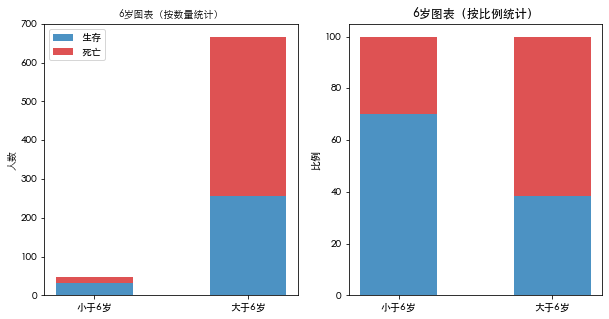

In [105]:
# 绘制6岁图表
gen_plot([up_to_6_survival_count, over_6_survival_count],
         [up_to_6_death_count, over_6_death_count],
         '6岁图表',
         ['小于6岁', '大于6岁'])

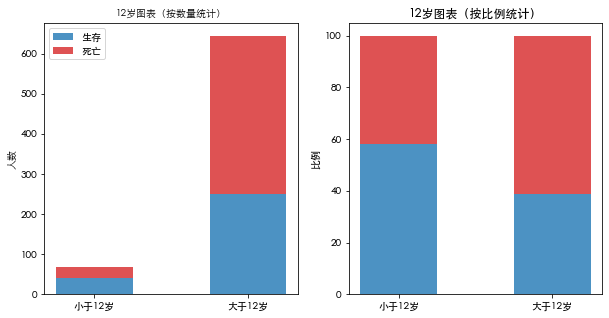

In [106]:
# 绘制12岁图表
gen_plot([up_to_12_survival_count, over_12_survival_count],
         [up_to_12_death_count, over_12_death_count],
         '12岁图表',
         ['小于12岁', '大于12岁'])

似乎6岁以下的儿童比6岁以上的人有更高的生存机会。

另外，12岁以下的儿童似乎比12岁以上的人有更高的生存机会，但比6岁以下的人要低。

这安慰了我们的第一个假设：你越年轻，你的生存机会就越高。

### 存活率与登船港口的相关性

我们最后的分析将根据登船的港口来研究生存的机会。
泰坦尼克号的乘客从三个不同的港口登船。

- 瑟堡(C)
- 皇后镇(Q)
- 南安普敦(S)

在做任何事情之前，我们应该先粗略地了解一下船票等级在乘客总数中是如何划分的。

In [107]:
total_passenger_count = len(df['Embarked'])
cherbourg_count = (df['Embarked'] == 'C').sum()
queenstown_count = (df['Embarked'] == 'Q').sum()
southampton_count = (df['Embarked'] == 'S').sum()

per_cherbourg =  cherbourg_count / total_passenger_count * 100
per_queenstown = queenstown_count / total_passenger_count * 100
per_southampton = southampton_count / total_passenger_count * 100

In [109]:
print('瑟堡 = %.2f%%'% per_cherbourg, ' | Count: ', cherbourg_count)
print('皇后镇 = %.2f%%'% per_queenstown, ' | Count: ', queenstown_count)
print('南安普顿 = %.2f%%'% per_southampton, ' | Count: ', southampton_count)

瑟堡 = 18.86%  | Count:  168
皇后镇 = 8.64%  | Count:  77
南安普顿 = 72.28%  | Count:  644


我们看到：

- 约19%的乘客从瑟堡登船
- 约9%的乘客从皇后镇登船
- 约72%的乘客从南安普敦上船

In [110]:
get_survival_rate(df, 'Embarked')

Survival rates: Embarked
C    27.192982
Q     8.771930
S    63.450292
Name: Survived, dtype: float64 
 
 Counts:  Embarked
C     93
Q     30
S    217
Name: Survived, dtype: int64


(Embarked
 C    27.192982
 Q     8.771930
 S    63.450292
 Name: Survived, dtype: float64, Embarked
 C     93
 Q     30
 S    217
 Name: Survived, dtype: int64)

通过这些生存率，我们可以看到。
- 来自瑟堡的乘客约占总人数的19%，但约占幸存者的27%。
- 来自皇后镇的乘客约占人数的9%，而幸存者约占9%。
- 来自南安普顿的乘客约占人数的72%，而幸存者约占63%。

让我们把这些结果可视化，以获得更好的理解。

准确地说，让我们看看生存率和死亡率是如何根据登船港的绝对数量和百分比演变的。

我们将再次使用get_counts函数。

In [113]:
cherbourg_survival_count = get_counts(df, 'Embarked', 'C', 1)
queenstown_survival_count = get_counts(df, 'Embarked', 'Q', 1)
southampton_survival_count = get_counts(df, 'Embarked', 'S', 1)
cherbourg_death_count = get_counts(df, 'Embarked', 'C', 0)
queenstown_death_count = get_counts(df, 'Embarked', 'Q', 0)
southampton_death_count = get_counts(df, 'Embarked', 'S', 0)

In [116]:
print('根据登船港口的生存人数')
print('瑟堡生存计数：', cherbourg_survival_count)
print('皇后镇级生存计数：', queenstown_survival_count)
print('南安普顿生存计数：', southampton_survival_count)
print('\n按登船港统计的伤亡人数')
print('瑟堡死亡人数：', cherbourg_death_count)
print('皇后镇死亡人数：', queenstown_death_count)
print('南安普顿死亡人数：', southampton_death_count)

根据登船港口的生存人数
瑟堡生存计数： 93
皇后镇级生存计数： 30
南安普顿生存计数： 217

按登船港统计的伤亡人数
瑟堡死亡人数： 75
皇后镇死亡人数： 47
南安普顿死亡人数： 427


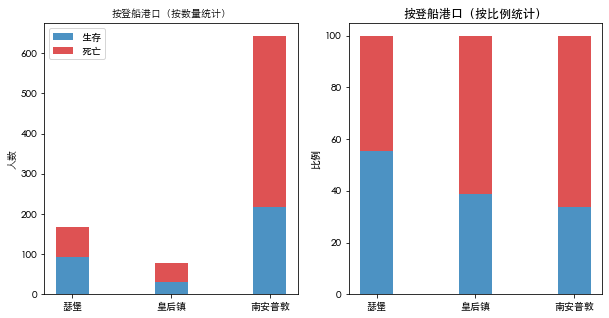

In [117]:
gen_plot([cherbourg_survival_count, queenstown_survival_count, southampton_survival_count],
         [cherbourg_death_count, queenstown_death_count, southampton_death_count],
         '按登船港口',
         ['瑟堡', '皇后镇', '南安普敦'])

我不认为妇女和儿童在这两个登船港的人数过多。那么我们可以做两个假设。

- 来自瑟堡的乘客往往拥有较高等级的船票，而来自南安普顿的乘客拥有较低等级的船票。
- 来自南安普顿的乘客的船舱更靠近撞击，或者更远离甲板。

我们可以检验第一个假设（类分布）。

In [118]:
# 瑟堡舱位分布
cherbourg_df = df[df['Embarked'] == 'C']
southampton_df = df[df['Embarked'] == 'S']

count_cherbourg_first = (cherbourg_df['Pclass'] == 1).sum()
count_cherbourg_second = (cherbourg_df['Pclass'] == 2).sum()
count_cherbourg_third = (cherbourg_df['Pclass'] == 3).sum()

per_cherbourg_first = count_cherbourg_first / cherbourg_count * 100
per_cherbourg_second = count_cherbourg_second / cherbourg_count * 100
per_cherbourg_third = count_cherbourg_third / cherbourg_count * 100


# Southampton distribution per class
count_southampton_first = (southampton_df['Pclass'] == 1).sum()
count_southampton_second = (southampton_df['Pclass'] == 2).sum()
count_southampton_third = (southampton_df['Pclass'] == 3).sum()

per_southampton_first = count_southampton_first / southampton_count * 100
per_southampton_second = count_southampton_second / southampton_count * 100
per_southampton_third = count_southampton_third / southampton_count * 100

In [119]:
print('瑟堡头等舱百分比 = ', per_cherbourg_first)
print('瑟堡二等舱百分比 = ', per_cherbourg_second)
print('瑟堡三等百分比 = ', per_cherbourg_third)
print('\n南安普顿头等舱百分比 = ', per_southampton_first)
print('南安普顿二等舱百分比 = ', per_southampton_second)
print('南安普顿三等舱百分比 = ', per_southampton_third)

瑟堡头等舱百分比 =  50.595238095238095
瑟堡二等舱百分比 =  10.119047619047619
瑟堡三等百分比 =  39.285714285714285

南安普顿头等舱百分比 =  19.72049689440994
南安普顿二等舱百分比 =  25.465838509316768
南安普顿三等舱百分比 =  54.81366459627329


看来我们的第一个假设是正确的。

- 来自瑟堡的约50%的乘客是头等舱
- 来自南安普敦的乘客中，约55%是二等舱。

这就解释了为什么瑟堡的乘客的存活率比南安普顿的乘客高。

让我们重申我们之前所做的组合分析（性别和舱位类别），在等式中添加登船港口因素。

In [120]:
df.groupby(['Sex', 'Pclass', 'Embarked'])['Survived'].mean() * 100

Sex     Pclass  Embarked
female  1       C            97.674419
                Q           100.000000
                S            95.833333
        2       C           100.000000
                Q           100.000000
                S            91.044776
        3       C            65.217391
                Q            72.727273
                S            37.500000
male    1       C            40.476190
                Q             0.000000
                S            35.443038
        2       C            20.000000
                Q             0.000000
                S            15.463918
        3       C            23.255814
                Q             7.692308
                S            12.830189
Name: Survived, dtype: float64

来自**瑟堡的头等舱女性**的生存机会： ≈ 97.67%

来自**南安普顿的杰克舱男子**的生存机会：≈12.83%。

### 结论

从以上分析中，我们倾向于得出这样的结论，即如果乘客希望有较高的生存机会。

- 他必须有一张高级别的舱位票
- 她们是女性
- 他们是年轻人
- 他们从瑟堡登船

相反，作为一个来自南安普顿的杰克舱老人，你的生存机会就会降低。

然而，有几件事我们应该牢记在心。

- 这个数据集包含891名乘客的数据，但总共有2228名乘客。我们只拥有三分之一多一点的数据。
- 有缺失的数据，特别是在年龄分析方面。
- 我们可以得到关于乘客的其他信息，比如他们离救生艇有多近。这可能也有影响。

### 番外

In [124]:
# 删除空数据
df_ages = df.dropna(how='any')

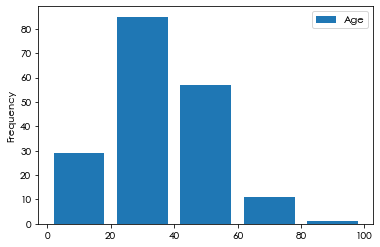

In [126]:
# 按年龄展示分布情况
df_ages[['Age']].plot(kind='hist',bins=[0,20,40,60,80,100],rwidth=0.8)
plt.show()

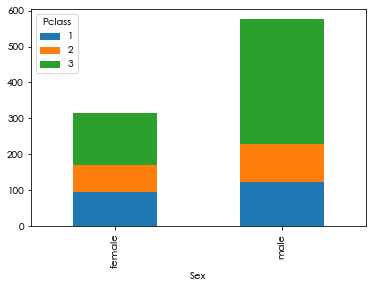

In [133]:
# 按舱位统计性别情况
df.groupby(['Sex','Pclass']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

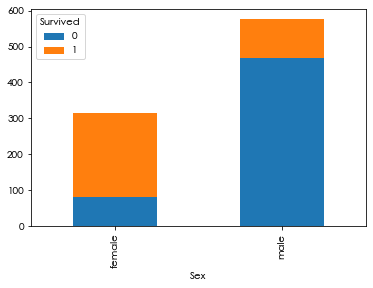

In [134]:
# 按性别进行存活率展示
df.groupby(['Sex','Survived']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

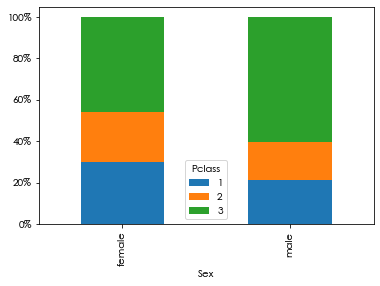

In [137]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

df.groupby(['Sex','Pclass']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

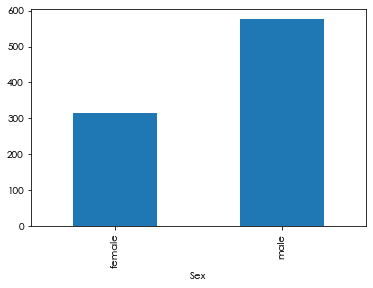

In [143]:
# 用groupby统计性别存活人数
df.groupby('Sex').count()["Survived"].plot(kind='bar')